# Final Project: Predicting Click-Through Rate using Logistic Regression
__`MIDS w261: Machine Learning at Scale | UC Berkeley School of Information | Fall 2018`__  
##### Group 2: Ramakrishnan Balasubramanian, Brandon Cummings, Laura Williams, Zhaoning Yu

## Section 1:  Introduction and Question Formulation

According to $eMarketer^1$  US advertisers will spend nearly \\$48B on display advertising in 2018. One primary challenge facing display advertisements is measuring and improving the effectiveness of such efforts. While there are many measures of effectiveness, one key metric that is broadly followed is _Click-Through-Rate_(CTR): the percentage of times a displayed ad is clicked on by a user.  Being able to predict which ads are more likely to be clicked on when presented to specific consumers is crucial to achieving better ROI on advertising spend.  This could depend on features of the ad (quality, message, content etc.), consumer characteristics (interest, demographics etc.), timing of the ad (time of day, day of week, event-triggered etc.) and interaction between these elements.  For instance, the relevance of an ad to a specific consumer may be a result of an event that has occured, *e.g.*, a consumer might be interested in an ad for a pre-concert dining offer when presented with such an ad after purchasing tickets for a specific concert or event - but once the event is over, they may no longer be interested in that specific ad.   


The __key question__ in this project is "Can we model click-through-behavior in order to better predict which customers might click on which ads - and use that to target the right ads to the right customers at the right time".  


The __primary goal__ of our analysis would be to create a model that predicts click-through rates given a set of ad/customer features.   

Given that average click-through-rates are extremely low - 0.09\% according to $eMarketer^2$ - any improvement in our ability to predict who might click on a specific display ad is likely to improve this performance metric.   The really low number also presents some analytical challenges - any data that we collect and analyze is going to be very imbalanced (only 9 out of 1000 ads are being clicked on, the positive class events are few and far between). Fortunately the data we received for the project already has sampled the underlying data to provide us with higher incidence of the positive class than might be found in the raw data (about 25%).

__Practical Significance:__  While on the surface improving CTR seems like a good idea - we need to take a broader perspective. Given the extremely low rate of Clicks on display ads, one is better off asking the broader question - do display ads improve sales (even if it they do not occur through direct clicks). The best way to answer this question is through a randomized, controlled trial - the material covered in W241. So, even if we have a model that improves our ability to predict which consumers will click on which ads, given that often display ads are paid for based on "impressions" delivered (driven by volume) and not necessarily "clicks" or "conversions" (driven by relevance), we may not see any improvements in our ability to predict CTRs translate into actual improvement in that metric's performance - especially if it comes at lower volumes of ads delivered!   

In addition since all the data received for this project are "hashed and masked" - we will not indulge in exploring interaction effects. There are too many combinations of interaction effects to explore and without a sound understanding of the underlying data elements, exploring all these interactions will be akin to p-value-hacking (we are bound to find some interactions of significance if we try many combinations).  

We chose logistic regression using gradient descent as our algorithm for modeling predictions based on this dataset.  Logistic regression is an obvious consideration, given the binary outcome variable (click vs. no click), and lends itself to potentially using regularization to narrow down the large number of features.

Throughout this project we asked ourselves "what is the learning objective of this exercise" and made decisions that were in accordance with that. This meant that we did not fully explore certain aspects with a data-science mind-set. However, we have identified where appropriate these opportunities for further exploration.    

  
$^1eMarketer$: https://www.emarketer.com/content/us-advertisers-will-spend-nearly-48-billion-on-digital-display-ads-in-2018-emarketer-estimates  
$^2 eMarketer$: https://www.emarketer.com/performance

### Notebook Setup
We tested our code on local machines using a small random sample of the dataset, and then ran all code, using the full dataset where appropriate, on a Google DataProc cluster. Each code block in this section is clearly marked for running this notebook either **LOCALLY** or on the **CLUSTER**.

Note that the kernel for the notebook needs to be changed depending on where the notebook is being run:  
LOCALLY: Python 3 kernel  
CLUSTER: Pyspark kernel  

In [1]:
# RUN THIS CELL for running in the CLUSTER
## Remember to change to the pyspark kernel

!pip install pyspark
!pip install --upgrade pip
!pip install --upgrade pandas
!pip install --upgrade google-api-python-client
!pip install scipy

from google.cloud import storage
storage_client = storage.Client()
bucket_name = 'final-project-w261-ads-data'
project_bucket = storage_client.get_bucket(bucket_name)


In [2]:
# RUN THIS CELL for running in both the CLUSTER and LOCALLY
import time
import math
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
from sklearn.metrics import f1_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.types import StructField, StructType, StringType, IntegerType, FloatType
from pyspark.sql.functions import regexp_replace, col, avg
from pyspark.sql.functions import * 
from pyspark.ml.feature import OneHotEncoder, VectorAssembler, VectorIndexer, StringIndexer
from pyspark.ml import Pipeline

%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
# RUN THIS CELL for starting spark on the CLUSTER
app_name = "final_project_notebook"
spark
sc = spark.sparkContext

In [ ]:
# RUN THIS CELL for staring spark LOCALLY 
app_name = "final_project_notebook"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

### Downloading and Sampling the Data

The full dataset is available from Criteo Labs and can be downloaded from this website:  
http://labs.criteo.com/2014/09/kaggle-contest-dataset-now-available-academic-use/

Its original use was in a Kaggle competition on CTR prediction.  

The file download (compressed) is 4.3GB, and must be downloaded directly from the website (there is not a command-line option to download this dataset.)

The file unzips and uncompresses into three files:
train.txt - 11.15GB
test.txt - 1.46GB
readme.txt - 2KB

The test.txt file does not have output value data and thus will not be used in this project.

Using the following code, we created 100 random splits of the train.txt file, and assigned 80 of the resulting files to training and 20 to testing. 

```
#!/bin/bash 
BEGIN {
filenamePrefix = "train_part"}
{r = int(rand()*100)
print($0)>> filenamePrefix"_"r".txt";
}
```

In the algorithm implemention in Section 4, 10% of the training data is additionally held back as development testing data.

To create a very small file (24MB in size) for testing our code, we used Spark's `takeSample` method to take a random sample from the full dataset, which we then saved in the same format as the full dataset in a file we called `sample_tiny.txt`.

## Section 2: Algorithm Explanation and Theory

Since the CTR prediction problem has a binary response variable $Y$, we decide to implement a logistic regression classifier for its simplicity and interpretability. In logistic regression, we assume there is approximately a linear relationship between the log-odds (logit) of the probability of click-through $p(\mathbf{x})$ and the features $\mathbf{x}$:

$$log(\frac{p(\mathbf{x})}{1-p(\mathbf{x})})=b + \mathbf{w}\cdot \mathbf{x}$$

Here, $b$ (intercept) and $\mathbf{w}$ (slope coefficients) are the model paramters.

Thus, the probability of click-through is:

$$p(\mathbf{x}) = \frac{e^{b + \mathbf{w}\cdot \mathbf{x}}}{1+e^{b + \mathbf{w}\cdot \mathbf{x}}}$$


While an Ordinary Least Squares (OLS) cost function is commonly used with Linear Regression, an OLS cost function used with Logistic Regression will not result in a convex function, and in this case gradient descent cannot be guaranteed to converge toward a global minimum.  Instead, the cross-entropy cost function when used with Logistic Regression, since this is a binary classification problem, results in a convex function that will converge toward a global minimum with gradient descent:

$$
J(\mathbf{w}, b) = -\frac{1}{n}\sum_{i=1}^{n}\left[y_i log(\sigma (\mathbf{w}^T\mathbf{x}_i + b)) +(1- y_i) log(1-\sigma (\mathbf{w}^T\mathbf{x}_i + b))\right]
$$

Where $\sigma(z)$ is the logistic (sigmoid) function:

$$\sigma(z) = \frac{1}{1+e^{-z}}$$

The goal of training is to minimize the cross-entropy cost function by iterating gradient descent steps.

We start by initializing with a BASELINE model. The BASELINE model is the starting point for the training, we first calculate the probability __$\hat{p}$__ of being label "1" using the training set, we set the initial bias $\beta_0$ as the logit of __$\hat{p}$__:

$$b_0 \equiv logit(\hat{p})=log(\frac{\hat{p}}{1-\hat{p}})$$
 
For each step, we compute the gradient as follows:

$$\nabla_{\mathbf{w}} J(\boldsymbol{w}, b) = \frac{2}{n}\,\sum_{i=1}^{n}\left[ \sigma(\mathbf{w}\cdot\mathbf{x}_i+b) - y_i\right] \cdot \mathbf{x}$$  

and update our model parameters by a simple update formula:  

$$ \mathbf{w_{new}} = \mathbf{w_{old}} - \nabla_{\mathbf{w}} J(\boldsymbol{w_{old}}, b) * \alpha$$
where $\alpha$ is the learning rate parameter.

We can also apply regularization by using following:

#### Ridge:

$$\nabla_{\mathbf{w}} J(\boldsymbol{w}, b) = \frac{2}{n}\,\sum_{i=1}^{n}\left[ \sigma(\mathbf{w}\cdot\mathbf{x}_i+b) - y_i\right] \cdot \mathbf{x} + 2 \lambda\mathbf{w}$$

#### Lasso:

$$\nabla_{\mathbf{w}} J(\boldsymbol{w}, b) = \frac{2}{n}\,\sum_{i=1}^{n}\left[ \sigma(\mathbf{w}\cdot\mathbf{x}_i+b) - y_i\right] \cdot \mathbf{x} + \lambda  \cdot sgn (\mathbf{w})$$

In our implementaion, the regularization can be turned on by setting parameters `regType` and `regParam`.

Our toy example in this section is run in a very small sample of the full dataset.  In this section we implement "Batch GradientDescent", where the model is trained on a single file (representing the full dataset for this toy example) in each iteration.

However, in Section 4, where we implement a scaled version of this algorithm, we will use a "miniBatch GradientDescent" implementation, where we process a much larger dataset that has been split into multiple files to process in each iteration of the gradient descent.

[1] G. James, D. Witten, T. Hastie, R. Tibshirani, An Introduction to Statistical Learning, Springer, 2014.

[2] https://ml-cheatsheet.readthedocs.io/en/latest/logistic_regression.html

[3] http://www.holehouse.org/mlclass/06_Logistic_Regression.html

[4] https://machinelearningmastery.com/logistic-regression-tutorial-for-machine-learning/

[5] https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

## 2.1: Toy Example Of Implementation  

Implementation starts with feature selection (to be discussed in Section 3 on EDA), then pre-processing (which includes normalization and one-hot encoding of categorical features), and finally running it through our model training.

Because feature selection will be covered below in Section 3 (EDA), here we just assume we have already decided which features to select for analysis.


### One-Hot Encoding

Cagetorical features (of which there are 26 in this dataset) cannot simply be translated into numbers within a single category.  Logistic regression treats numbers as having a mathematical or ranked relationship with other numbers in the same feature, and hashing categorical features to numbers would impose relationships between categories that might not actually exist.  A common solution to this problem is to one-hot encode categorical features, as described below.  One drawback of this solution is the potentially large number of features created by the one-hot encoding process - we address this problem in Section 3 on EDA below.

One-Hot encoding is a way to transform categorical data into number representations to feed into machine learning models. The idea is highlighted below with a simple game summary of people after playing at a baseball tournament:

|   Team   | FirstName | AtBats | Victory |
|  ------  |  ------   | ------ | ------  |
|   blue   |   sue     |   2    |    0    |
|   green  |   bill    |   2    |    1    |
|   green  |   jenn    |   3    |    1    |
|   white  |   debb    |   4    |    0    |

If you wanted to use this data to help predict victories using something like logistic regression, you would need to have an outcome row that has all number representations of the categorical variables.

There are 3 steps for one-hot encoding our dataset:

#### Step 1:

For each of our categorical variable columns we are going to create an additional column that indexes the string values into numbers, which will be more computationally efficient to use later. So each unique value for each column gets assigned its own unique number and is used to represent that string in the index column (notice team green shows twice in the Team_index column as the number 1).

| Team     | Team_index | FirstName | FirstName_index | AtBats | Victory |
| ------   | ---------- | --------- | --------------- | ------ | ------  |
|   blue   |      0     |    sue    |         0       |    2   |    0    |
|   green  |      1     |    bill   |         1       |    2   |    1    |
|   green  |      1     |    jenn   |         2       |    3   |    1    |
|   white  |      2     |    debb   |         3       |    4   |    0    |

After we have the index representation of the categorical values, we will drop the original columns

| Team_index | FirstName_index | AtBats | Victory |
| ---------- | --------------- | ------ | ------  |
|      0     |         0       |    2   |    0    |
|      1     |         1       |    2   |    1    |
|      1     |         2       |    3   |    1    |
|      2     |         3       |    4   |    0    |

#### Step 2:

Now that we have index representations of our categorical variables, we can efficiently start out one-hot encoding process for our categorical index columns only. Every unique value in each of our columns will get its own unique column with a value in the rows of either a 1 or 0 to represent if this row has that value, like so:  

| Team_index=0 | Team_index=1 | Team_index=2 | FirstName_index=0 | FirstName_index=1 | FirstName_index=2|
| -----------  | -----------  | -----------  | ----------------  | ----------------  | ----------------  |
|      1       |      0       |      0       |         1         |         0         |         0         |
|      0       |      1       |      0       |         0         |         1         |         0         |
|      0       |      1       |      0       |         0         |         0         |         1         |
|      0       |      0       |      1       |         0         |         0         |         0         |



 | FirstName_index=3 | AtBats | Victory |
 | ----------------  | ------ | ------  |
 |         0         |    2   |    0    |
 |        0         |    2   |    1    |
 |         0         |    3   |    1    |
|         1         |    3   |    0    |


Notice that `Team_index=1` column has 1 twice because each of the rows team were of index 1. Also note, we do not make any alterations to our continuous variables for this transformation because they are already numerical.

#### Step 3:

Technically our one-hot encoding is complete, but for much easier processing and storing, we are going to combine these into one column called `features` and another column `target`. The `features` column will be values of arrays of each of the values in the row and the `target` column will be our target outcome of previous column `Victory` per row.

|           features          |  target   |
| --------------------------  | --------- |
|      [1,0,0,1,0,0,0,2]      |     0     |
|      [0,1,0,0,1,0,0,2]      |     1     |
|      [0,1,0,0,0,1,0,3]      |     1     |
|      [0,0,1,0,0,0,1,3]      |     0     |

In [ ]:
# Use a sample file for running LOCALLY
dataFile = 'data/sample_tiny.txt'

In [4]:
# Use a sample file for SHARED CLUSTER
dataFile = 'gs://ads-impression-data/sample_tiny.txt'

In [5]:
cont_column_indexes = [i for i in range(0,5)]
categorical_column_indexes = [i for i in range(5,10)]
target_column_index = [10]

columnNames = ['intCol1', 'intCol2','intCol3','intCol4','intCol5', 
               'catCol1', 'catCol2', 'catCol3', 'catCol4', 'catCol5', 
               'Y']
category_vector_cols = [columnNames[i]+"_vector" for i in categorical_column_indexes]

def get_toy_data(row):
    """Select feature subset of full dataset for use in toy dataset."""
    target = int(row[0])
    toy_row = []                 
    for idx, val in enumerate(row[1:]):
        if idx in range(1,6):          # 5 continuous variables
            if val == '':
                toy_row.append(0.0)
            else:
                toy_row.append(float(val))
        if idx in range(21,26):        # 5 category variables
            if val == '':
                toy_row.append('NA')
            else:
                toy_row.append(val)
    toy_row.append(target)             # lastly target variable
    return toy_row

subsetRDD = sc.textFile(dataFile) \
            .map(lambda x: x.split('\t')) \
            .map(get_toy_data) \
            .take(1000)

dataRDD = sc.parallelize(subsetRDD).collect()
dataRDD[0]

[1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 'a73ee510',
 '86eb6d2e',
 '7833fda9',
 '2a52f3da',
 '952c94a3',
 0]

In [6]:
def create_dataframe(dataRDD):
    """
    This takes in the original RDD and converts it to a dataframe with the correct schema 
    for the toy dataset
    Args:
        row - array([intCol1, intCol2, ..., catCol4, catCol5, targetVariable]) 
    Returns:
        dataFrame - | intCol1 | intCol2| ... | catCol4 | catcol5 | targetVariable | 
    """
    cont_schema = [StructField(columnNames[i], FloatType(), True) for i in cont_column_indexes]
    cat_schema = [StructField(columnNames[i], StringType(), True) for i in categorical_column_indexes]
    int_schema = [StructField(columnNames[i], IntegerType(), True) for i in target_column_index]
    schema_order = cont_schema + cat_schema + int_schema
    schema = StructType(schema_order)
    df = spark.createDataFrame(dataRDD, schema)
    return df
dataDF    = create_dataframe(dataRDD)
dataDF.show()

+-------+-------+-------+--------+-------+--------+--------+--------+--------+--------+---+
|intCol1|intCol2|intCol3| intCol4|intCol5| catCol1| catCol2| catCol3| catCol4| catCol5|  Y|
+-------+-------+-------+--------+-------+--------+--------+--------+--------+--------+---+
|    1.0|    1.0|    0.0|     1.0|    0.0|a73ee510|86eb6d2e|7833fda9|2a52f3da|952c94a3|  0|
|   13.0|    3.0|   12.0|     2.0|    6.0|a73ee510|70962768|ab066900|628b4b77|5d4198ed|  1|
|    1.0|    7.0|   33.0|  7227.0|   68.0|a73ee510|ea23b002|f66047e5|f9adf54b|13c89cc4|  0|
|    2.0|    4.0|    5.0|  2669.0|    0.0|a73ee510|3b08e48b|d66168dc|cc40dc05|54c30969|  0|
|   13.0|    2.0|    2.0| 24553.0|  903.0|a73ee510|49d1ad89|7f8ffe57|6bb8dd1e|46f42a63|  0|
|    0.0|   30.0|   10.0|   475.0|   12.0|a73ee510|3b08e48b|f58236c6|623049e6|8b11c4b8|  0|
|    1.0|    6.0|    2.0|  1411.0|    0.0|a73ee510|441dd290|7f8ffe57|aadf08c8|46f42a63|  0|
|    0.0|    5.0|    0.0|  4629.0|   49.0|a73ee510|222ae0ea|4ba74619|526efc5a|87

In [7]:
def create_column_indexes(df):
    """
    This takes the dataframe and converts all categorical variables columns to index columns 
    with one unique number representing one unique string in that column using StringIndexer.
    This then drops the original categorical columns.
    Args:
        dataFrame - | intCol1 | intCol2| ... | catCol4 | catcol5 | targetVariable | 
    Returns:
        dataFrame - | intCol1 | intCol2| ... | indexCatCol4 | indexCatcol5 | targetVariable | 
    """
    indexers = [StringIndexer(inputCol=columnNames[i], outputCol=columnNames[i]+"_index").fit(df) for 
                i in categorical_column_indexes ]
    pipeline = Pipeline(stages=indexers)
    df_r = pipeline.fit(df).transform(df)
    for i in categorical_column_indexes:
        df_r = df_r.drop(columnNames[i])
    return df_r
indexDF   = create_column_indexes(dataDF)
indexDF.show()

+-------+-------+-------+--------+-------+---+-------------+-------------+-------------+-------------+-------------+
|intCol1|intCol2|intCol3| intCol4|intCol5|  Y|catCol1_index|catCol2_index|catCol3_index|catCol4_index|catCol5_index|
+-------+-------+-------+--------+-------+---+-------------+-------------+-------------+-------------+-------------+
|    1.0|    1.0|    0.0|     1.0|    0.0|  0|          0.0|        405.0|        447.0|        501.0|        214.0|
|   13.0|    3.0|   12.0|     2.0|    6.0|  1|          0.0|         42.0|        161.0|        328.0|         83.0|
|    1.0|    7.0|   33.0|  7227.0|   68.0|  0|          0.0|        128.0|        553.0|         80.0|        357.0|
|    2.0|    4.0|    5.0|  2669.0|    0.0|  0|          0.0|          0.0|        104.0|        178.0|         16.0|
|   13.0|    2.0|    2.0| 24553.0|  903.0|  0|          0.0|          7.0|          3.0|        597.0|          3.0|
|    0.0|   30.0|   10.0|   475.0|   12.0|  0|          0.0|    

In [8]:
def one_hot_encode_df(df_r):
    """
    This takes the dataframe that has had its categorical variables transformed to index columns
    and outputs a one-hot-encoded vector dataframe using OneHotEncoder that creates a new column 
    for each index column that has the value of a binary vector 
    where at most one value will be 1 and the rest 0s.
    Args:
        dataFrame - | intCol1 | intCol2| ... | indexCatCol4 | indexCatcol5 | targetVariable | 
    Returns:
        dataFrame - | intCol1 | intCol2| ... | vectorCatCol4 | vectorCatcol5 | targetVariable | 
    """
    encoded_df = df_r
    encoders = {}
    for i in range(len(categorical_column_indexes)):
        encoders[i] = OneHotEncoder(inputCol=columnNames[categorical_column_indexes[i]] + "_index", 
                                    outputCol=columnNames[categorical_column_indexes[i]] +"_vector")
    for i in range(len(categorical_column_indexes)):
        encoded_df = encoders[i].transform(encoded_df)
    return encoded_df
encodedDF = one_hot_encode_df(indexDF)
encodedDF.show()

+-------+-------+-------+--------+-------+---+-------------+-------------+-------------+-------------+-------------+--------------+-----------------+-----------------+-----------------+-----------------+
|intCol1|intCol2|intCol3| intCol4|intCol5|  Y|catCol1_index|catCol2_index|catCol3_index|catCol4_index|catCol5_index|catCol1_vector|   catCol2_vector|   catCol3_vector|   catCol4_vector|   catCol5_vector|
+-------+-------+-------+--------+-------+---+-------------+-------------+-------------+-------------+-------------+--------------+-----------------+-----------------+-----------------+-----------------+
|    1.0|    1.0|    0.0|     1.0|    0.0|  0|          0.0|        405.0|        447.0|        501.0|        214.0| (1,[0],[1.0])|(581,[405],[1.0])|(566,[447],[1.0])|(719,[501],[1.0])|(515,[214],[1.0])|
|   13.0|    3.0|   12.0|     2.0|    6.0|  1|          0.0|         42.0|        161.0|        328.0|         83.0| (1,[0],[1.0])| (581,[42],[1.0])|(566,[161],[1.0])|(719,[328],[1.0])

In [9]:
def assemble_vector(encoded_df):
    """
    This takes the dataframe with the continuous, vector, and target variable columns and uses VectorAssembler
    to combine them into one dataframe with 2 columns, one with the combined features and the other for the target
    variable.
    Args:
        dataFrame - | intCol1 | intCol2| ... | vectorCatCol4 | vectorCatcol5 | targetVariable | 
    Returns:
        dataFrame - | features | targetVariable | 
    """
    assembler = VectorAssembler(
        inputCols= [columnNames[i] for i in cont_column_indexes] + category_vector_cols,
        outputCol="features")
    output = assembler.transform(encoded_df)
    vector_df = output.select('features', 'Y')
    return vector_df


vectorDF  = assemble_vector(encodedDF)
vectorDF.show()

+--------------------+---+
|            features|  Y|
+--------------------+---+
|(2387,[0,1,3,5,41...|  0|
|(2387,[0,1,2,3,4,...|  1|
|(2387,[0,1,2,3,4,...|  0|
|(2387,[0,1,2,3,5,...|  0|
|(2387,[0,1,2,3,4,...|  0|
|(2387,[1,2,3,4,5,...|  0|
|(2387,[0,1,2,3,5,...|  0|
|(2387,[1,3,4,5,45...|  1|
|(2387,[0,1,2,3,4,...|  1|
|(2387,[1,2,3,4,5,...|  0|
|(2387,[0,1,3,4,5,...|  0|
|(2387,[0,3,4,5,6,...|  1|
|(2387,[0,1,3,4,5,...|  0|
|(2387,[3,27,610,1...|  0|
|(2387,[1,2,3,4,5,...|  0|
|(2387,[1,2,3,4,5,...|  0|
|(2387,[0,1,2,3,4,...|  0|
|(2387,[0,3,4,5,52...|  0|
|(2387,[0,3,4,5,24...|  1|
|(2387,[1,3,4,5,6,...|  0|
+--------------------+---+
only showing top 20 rows



In [10]:
# turn DF to RDD and select the first 10 columns for a toy example
toyRDD    = vectorDF.rdd.map(lambda line: (np.array(line[0]), line[1]))\
                        .map(lambda x: (x[0][:10], x[1]))\
                        .cache()

### Normalization of data

We split the data into train, dev, test set, and scale the features using the mean and stdev of the train set.

In [11]:
# First we split the toyRDD into 3 RDDs and normalize the scale using Train data

# part d - helper function to split and normalize the data 
def normalize_and_split_3(dataRDD):
    """
    Scale and center data round mean of each feature of train and split into train, dev and test
    Args:
        dataRDD - records are tuples of (features_array, y)
    Returns:
        NormedTrainRDD, NormedDevRDD, NormedTestRDD - records are tuples of (features_array, y)
    """
    # Split the data into Train, Dev, Test #######################################
    TrainRDD, EvalRDD, TestRDD = dataRDD.randomSplit([0.70, 0.10, 0.20], seed = 1)
    print(f"... held out {TestRDD.count()} records for test and assigned {TrainRDD.count()} for training \
          \nand {EvalRDD.count()} for development.")
    
    # Find the Mean and Stdev of the train set ###################################
    TrainFeatureMeans = TrainRDD.map(lambda x: x[0]).mean()
    TrainFeatureStdev = np.sqrt(TrainRDD.map(lambda x: x[0]).variance())
    
    # Normalize the data sets #####################################################
    NormedTrainRDD = TrainRDD.map(lambda x: ((x[0] - TrainFeatureMeans)/TrainFeatureStdev, x[1]))
    NormedDevRDD = EvalRDD.map(lambda x: ((x[0] - TrainFeatureMeans)/TrainFeatureStdev, x[1]))
    NormedTestRDD = TestRDD.map(lambda x: ((x[0] - TrainFeatureMeans)/TrainFeatureStdev, x[1]))
    
    return NormedTrainRDD, NormedDevRDD, NormedTestRDD

# Run the function to get train, dev, test set
NormedTrainRDD, NormedDevRDD, NormedTestRDD = normalize_and_split_3(toyRDD)

... held out 222 records for test and assigned 681 for training           
and 97 for development.


Next, we define a baseline model using the P(Y=1) estimate based on the train set.

In [12]:
# part a - mean and variance of the outcome variable 
meanQuality = NormedTrainRDD.map(lambda x: x[1]).mean()             

# Inverse of logistic
def logit(p):
    return np.log(p / (1 - p))

print(f"Estimated P(Y=1): {meanQuality}")
print(f"Logit of P(Y=1): {logit(meanQuality)}")

# define your baseline model here
BASELINE = np.append([logit(meanQuality)], np.zeros(NormedTrainRDD.take(1)[0][0].shape[0]))

Estimated P(Y=1): 0.25256975036710705
Logit of P(Y=1): -1.0849535397370704


We define the Cross-Entropy Loss function and calculate the loss for Train, Dev, Test for the BASELINE model:

In [13]:
# function to compute Cross-Entropy loss 
def CELoss(dataRDD, W):
    """
    Compute Cross Entropy Loss
    Args:
        dataRDD - each record is a tuple of (features_array, y)
        W       - (array) model coefficients with bias at index 0
    """
    # sigmoid function for calculating the logistic
    sigmoid = np.vectorize(lambda x: 1/(1+math.exp(-x)))
    
    # Note the features need to be augmented to be (1, features) since W has bias at index 0
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1]))

    w = sc.broadcast(W)   
    loss = augmentedData.map(lambda x: (-np.log(sigmoid(np.dot(w.value, x[0]))) * x[1])-(1-x[1])*np.log(1-sigmoid(np.dot(w.value, x[0]))))\
                        .mean()
    
    return loss

In [14]:
#  compute the loss for the baseline model 
assert len(BASELINE) == len(NormedTrainRDD.take(1)[0][0]) + 1, "Double check model dimensions"
print(f"Baseline model loss on Train: {CELoss(NormedTrainRDD, BASELINE)}")
print(f"Baseline model loss on Dev: {CELoss(NormedDevRDD, BASELINE)}")
print(f"Baseline model loss on Test: {CELoss(NormedTestRDD, BASELINE)}")

Baseline model loss on Train: 0.5651407342902904
Baseline model loss on Dev: 0.5707414905621517
Baseline model loss on Test: 0.545247551159024


We define the functions for gradient descent:

In [15]:
# function for running one-step of gradient descent with regularization
def GDUpdate_wReg(dataRDD, W, learningRate = 0.1, regType = None, regParam = 0.1):
    """
    Perform one gradient descent step/update with ridge or lasso regularization.
    Args:
        dataRDD - tuple of (features_array, y)
        W       - (array) model coefficients with bias at index 0
        learningRate - (float) defaults to 0.1
        regType - (str) 'ridge' or 'lasso', defaults to None
        regParam - (float) regularization term coefficient
    Returns:
        model   - (array) updated coefficients, bias still at index 0
    """
    # define the sigmoid function
    sigmoid = np.vectorize(lambda x: 1/(1+math.exp(-x)))  
    
    # note the features need to be augmented to (1, features) since W has bias at index 0
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1]))    
    
    new_model = None
    
    w = sc.broadcast(W)
    
    if regType == 'ridge':
        grad = augmentedData.map(lambda x: 2*(sigmoid(np.dot(x[0], w.value)) - x[1]) * x[0]).mean() + np.append([0], 2 * regParam * W[1:])
    elif regType == 'lasso':
        grad = augmentedData.map(lambda x: 2*(sigmoid(np.dot(x[0], w.value)) - x[1]) * x[0]).mean() + np.append([0], regParam * np.sign(W[1:]))
    else:        
        grad = augmentedData.map(lambda x: 2*(sigmoid(np.dot(x[0], w.value)) - x[1]) * x[0]).mean()
      
    new_model = W - learningRate * grad        
    
    return new_model

In [16]:
#  function for running regular/ridge/lasso gradient descent interations
def Batch_GD(trainRDD, devRDD, wInit, nSteps = 20, learningRate = 0.1,
                         regType = None, regParam = 0.1, verbose = False, evaluate_every = 10):
    """
    Perform nSteps iterations of regularized gradient descent and 
    track loss on a dev and train set. Return lists of
    dev/train loss and the models themselves.
    """
    # initialize lists to track model performance
    train_history, dev_history, model_history = [], [], []
    
    # perform n updates & compute test and train loss after each
    model = wInit
    
    start = time.time()
    
    for idx in range(nSteps):  
        # update the model
        model = GDUpdate_wReg(trainRDD, model, learningRate, regType, regParam)
        
        # calculate loss and save model only at "evaluate_every" intervals and at the end
        if idx == (nSteps-1) or idx == 0 or (idx+1) % evaluate_every == 0:
            # keep track of dev/train loss for plotting
            training_loss = CELoss(trainRDD, model)
            dev_loss = CELoss(devRDD, model)
            
            train_history.append(training_loss)
            dev_history.append(dev_loss)
            model_history.append(model)

            # console output if desired
            if verbose:
                print("----------")
                print(f"STEP: {idx+1}")
                print(f"training loss: {np.round(training_loss,4)}")
                print(f"eval loss: {np.round(dev_loss,4)}")
                
    print(f"\n... trained {nSteps} iterations in {time.time() - start} seconds")            
                
    return train_history, dev_history, model_history

In [17]:
# run 50 iterations without regularization
wInit = BASELINE

results = Batch_GD(NormedTrainRDD, NormedDevRDD, wInit, nSteps = 50, verbose=True, evaluate_every=10)

train_loss, dev_loss, models = results

----------
STEP: 1
training loss: 0.5637
eval loss: 0.57
----------
STEP: 10
training loss: 0.5549
eval loss: 0.5657
----------
STEP: 20
training loss: 0.5499
eval loss: 0.5633
----------
STEP: 30
training loss: 0.5471
eval loss: 0.5619
----------
STEP: 40
training loss: 0.5454
eval loss: 0.5608
----------
STEP: 50
training loss: 0.5442
eval loss: 0.56

... trained 50 iterations in 7.233808517456055 seconds


## Section 3: EDA & Discussion of Challenges

### 3.1 General Observations about the data
 -  There are over 45M records.   
 -  We have randomly assigned 80% of the data for training our models.  
 -  Data is randomly split into 100 individual files so train/test split is achieved by reading the appropriate files.
 -  There are 13 integer variables and 26 hashed categorical variables and one Outcome variable.   
 -  We will use the following labeling convention for the variables in the dataset:  
    -  Y: outcome  
    -  x01-x13: Integer valued features  
    -  c01-c26: categorical features (hashed values)   
    
### 3.2 Random Split and Scaling  
- Using Unix shell scripting, we read the 45M record train.txt dataset and partitioned it randomly into 100 smaller files. 
- This enabled us to test our code on a 1% random sample (by just reading 1 of the input files)
- It allowed us to compute some statistics very quickly on a 10% sample when we could justify using a random sample (eg t-tests for the continuous variables against the outcome) 
- We were also able to use the same mechanism to split our training data into train/dev groups for model training and testing.
- Lastly, we intended to use this as a way to measure how scalable our code is. So we could run our code on an increasing subset of the original training data (say 1%, 10%, 20%, 30% etc.) and plot the time taken to process the data. A well designed scalable code should show linear performance (i.e. it should take us twice as long to process twice as much data given the same amount of computing power).  We did not have time to conduct the scaling experiment as explained above; this would be a good next step to add for critical evaluation of the scalability of our implementation.  

### 3.3 Missing Values 
-  Outcome variable Y has zero missing values.
-  Integer variables (x01 - x13) have missing values. 
    -  Variables with very few missing values: x02, x05, x07, x08, x09, x11;  
    -  x03, x04, x06, x13 have about 20% missing values; 
    -  x01, x10 have about 45% missing and x12 has 76% missing. 
-  Categorical Variables (c01-c26): some have a lot of missing values as well. 
    -  c01-c05; c07-c18, c23, c24 have very few missing values (less than 4%).  
    -  c06 has about 12% missing;  
    -  c19,c20,c25,c26 have 44% missing and c22 has 76% missing.  
    
#### 3.3.1 Recommendations on how to handle missing values in the data:  

-  Integer variables:  Some of the integer valued variables may be treated as "discrete" or categorical variables (see below on how to handle missing variables for categorical variables).  The remaining integer-valued variables can be treated as "continuous" variables; Recommend treating missing values by replacing them with the mean value for the feature.

-  Categorical variables: Missing values can be treated as a category of its own during the one-hot encoding process. 


### 3.4 Count of Unique values:   

-  __Integer variables:__  Variables x10, x11 have relatively few unique values suggesting that we may be able treat these as categorical variables. The simplest approach would be to treat other integer variables as continuous numerical data in the first cut of our data analysis.

-  __Categorical variables:__ There are some categorical variables that have relatively few unique levels/values (like c06, c09, c14, c18, c20, c22, c23).  There are a few where there are more levels (in the 100-500 range) but many of those unique values have very few records associated with them. And there are many categorical variables that have many unique entries (e.g. c04, c07, c16).  
-  __CHALLENGES__: The extremely large number of unique values (levels) for many of the categorical variables presents a great challenge for modeling.  If we want to retain all the levels using one-hot encoding, we will be dealing with a massively large dimensional problem - in addition, there are not many records for many of these levels.    
-  __Recommendations:__  Based on the observations of unique values, here are the recommendations for how to handle categorical variables - so that we can reduce the dimensionality of the data significantly.  
    -   For each variable, combine all values that have very few counts (less than 100) into a separate "small count" category for that variable.   
    -  For those categorical variables with  few distinct levels (after handling small counts as above), we can handle those as-is.  There are grouped in the EDA code below under `CompactCategoricalVariables`  
    - Criteria for selecting features into `CompactCategoricalVariables`: We looked at the count of unique values for each categorical variable (after accumulating all the values with small counts) - and treated any variable that had less than 200 unique values as "Compact". Unique values after accumulating small counts are identified in the `rest` column in the output to the `uniqueCountStats` function below.
    -  For categorical variables that have many levels (after handling those with small counts) we will process them as follows. These are grouped under the variable `LongCategoricalVariables` in the EDA code below.
        -  bucket the levels into 3 groups based on the % records with outcome Y = 0
        -  Low0: all levels for the variable where % of records with outcome Y=0 is less than 30%
        -  Mid0: all levels for the variable where % of records with outcome Y=0 is between 30% and 70%
        - High0: all levels for the variable where % of records with outcome Y=0 is > 70%





### 3.5 Feature Selection Criteria:
-  __Integer Variables:__  For those integer variables that are to be treated as "continuous" conduct a t-test of means for Y=1 vs Y=0.  Use the p-value of this test to determine if a variable is to be included in the model.  Based on the actual test results - we kept all the continuous variables for the final model.

-  __Categorical variables:__  For all the variables treated as "categorical variables" (including the integer variables that are to be treated as categorical variables),  conduct a chi-square test of independence between each categorical variable and the outcome variable.  Compute $Cramer's V^1$ statistic to get a measure of the association between the outcome variable and the feature.  We can use this as a way to select the features to include in our model.  We used a cutoff point of 0.15 for Cramer's V value.  This resulted in 16 catgeorical variables that were used the modeling phase. We could potentially change the criteria for feature selection to see if we can achieve similar results with a simpler model.   

$^1$Cramér, Harald. 1946. Mathematical Methods of Statistics. Princeton: Princeton University Press, page 282 (Chapter 21. The two-dimensional case).

### Modeling Approach:
* Given the nature of the problem and the EDA of the data there are two model families that we should explore:
    * Logistic Regression: Given the outcome variable is a 1/0 variable this is an obvious choice
    * Decision Trees: Given the nature of the feature space and the number of missing values, the family of Decision Tree based models would be an excellent choice for this problem and would require substantially less, or no, pre-processing of the data.

We have implemented the LR model from scratch below.  We did not explore implementing the Decision Tree algorithm from scratch because of the complexities invovled in that. This could be easily  explored using Spark's implementation of Decision Trees. 

### Performing EDA
The code below supports the EDA discussion above.  

First choose the datafile on which to perform EDA - note the different files choosen when running **LOCALLY** vs. running on the **CLUSTER**.

In [ ]:
# Use a very small testing file for running LOCALLY
dataFile = 'data/sample_tiny.txt'
dataFileSample = 'data/sample_tiny.txt'

In [18]:
# Use the dataset and a 10% sample for running on the CLUSTER
# small % of the dataset for testing
# dataFile = 'gs://w261-final-project-data-1/train_part_0.txt'
# OR the full training dataset (80% of the full dataset):
dataFile = 'gs://w261-final-project-data-1/train_part_*.txt'
# Use a 10% sample for conducting t-tests on continous variables
dataFileSample = 'gs://w261-final-project-data-1/train_part_1*.txt' 

In [19]:
# load into RDDs for EDA
inRDD = sc.textFile(dataFile) \
          .map(lambda x: x.split('\t'))

inSampleRDD = sc.textFile(dataFileSample) \
                .map(lambda x: x.split('\t'))  

In [20]:
#Generate  Variable names: x01-x13 for integer features and c01-c26 for categorical features
outcomeCOL = ['Y']
integerCOLS = []
categoryCOLS = []
for i in range(1,14):
    integerCOLS.append('x'+format(i,'02d'))
for i in range(1,27):
    categoryCOLS.append('c'+format(i,'02d'))
allCOLS = outcomeCOL + integerCOLS + categoryCOLS
print(allCOLS)

['Y', 'x01', 'x02', 'x03', 'x04', 'x05', 'x06', 'x07', 'x08', 'x09', 'x10', 'x11', 'x12', 'x13', 'c01', 'c02', 'c03', 'c04', 'c05', 'c06', 'c07', 'c08', 'c09', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19', 'c20', 'c21', 'c22', 'c23', 'c24', 'c25', 'c26']


In [21]:
### In this section we will create a data structure that looks like the following:
### COLName|Value, Count*(Y=0), Count(Y=1) 
### The key for this record would be "COLName|Value" 

def makeCompositeKey(line):
    """ Given a line of record, create the composite key outcome|colname|value and yield (key,1)"""
    len_line = len(line)
    for i in range(1,40):
        composite_key = line[0] + "|" + allCOLS[i] + "|"+ line[i]
        yield (composite_key,1)
        
def pivot(line):
    """ Pivot outcome values into two columns of counts"""
    outcome, colname, value  = line[0].split('|')
    if outcome == '0':
        count0 = line[1]
        count1 = 0
    elif outcome=='1':
        count1 = line[1]
        count0 =0
    else:
        print("**** FATAL OUTCOME ERROR *****")
    return (colname+"|"+value, (count0, count1))
    
start = time.time()
cRDD = inRDD.flatMap(makeCompositeKey) \
            .reduceByKey(lambda x,y: x+y) \
            .map(pivot) \
            .reduceByKey(lambda x,y: (x[0]+y[0], x[1]+y[1]))
cRDD.cache()
recCount = cRDD.count()
print("Prep -1 took:", time.time()-start, " seconds: Records:", recCount )
cRDD.take(5)

Prep -1 took: 479.55309891700745  seconds: Records: 28720074


[('c24|08b0ce98', (171393, 40534)),
 ('c03|f9aed79a', (4375, 8817)),
 ('c03|e0039e9a', (8, 0)),
 ('x05|4913', (798, 212)),
 ('c13|5029598e', (9605, 1035))]

In [22]:
#Count number of missing records for each variable - compute proportion
startTime = time.time()
missingCount = cRDD.filter(lambda x: x[0].split('|')[1] == '' ) \
                 .map(lambda x: (x[0].split('|')[0], x[1][0]+x[1][1]) ).collect()
totalCount = cRDD.map(lambda x: (x[0].split('|')[0], x[1][0]+x[1][1]) ) \
                    .reduceByKey(lambda x, y: x+y).collect()
print("Time taken for counts:" , time.time() - startTime)
print("Column\t%Miss\tTotalCount\tMissing")
for c in allCOLS[1:]:
    tC = list(filter(lambda x: x[0] == c, totalCount))[0][1]
    mC = list(filter(lambda x: x[0] == c, missingCount))
    if mC == []:
        mC = 0
    else:
        mC = mC[0][1]
    print(c,'\t', np.round(100*mC/tC,1),'\t', tC,'\t', mC)

Time taken for counts: 28.992184162139893
Column	%Miss	TotalCount	Missing
x01 	 45.4 	 36667712 	 16633219
x02 	 0.0 	 36667712 	 0
x03 	 21.5 	 36667712 	 7870784
x04 	 21.7 	 36667712 	 7948199
x05 	 2.6 	 36667712 	 946491
x06 	 22.4 	 36667712 	 8201453
x07 	 4.3 	 36667712 	 1586588
x08 	 0.0 	 36667712 	 18148
x09 	 4.3 	 36667712 	 1586588
x10 	 45.4 	 36667712 	 16633219
x11 	 4.3 	 36667712 	 1586588
x12 	 76.5 	 36667712 	 28053238
x13 	 21.7 	 36667712 	 7948199
c01 	 0.0 	 36667712 	 0
c02 	 0.0 	 36667712 	 0
c03 	 3.4 	 36667712 	 1248281
c04 	 3.4 	 36667712 	 1248281
c05 	 0.0 	 36667712 	 0
c06 	 12.1 	 36667712 	 4431948
c07 	 0.0 	 36667712 	 0
c08 	 0.0 	 36667712 	 0
c09 	 0.0 	 36667712 	 0
c10 	 0.0 	 36667712 	 0
c11 	 0.0 	 36667712 	 0
c12 	 3.4 	 36667712 	 1248281
c13 	 0.0 	 36667712 	 0
c14 	 0.0 	 36667712 	 0
c15 	 0.0 	 36667712 	 0
c16 	 3.4 	 36667712 	 1248281
c17 	 0.0 	 36667712 	 0
c18 	 0.0 	 36667712 	 0
c19 	 44.0 	 36667712 	 16137396
c20 	 44

In [23]:
### For each column, get total number of unique values and number of unique values with small counts
### We will use this to figure out which categories should be retained as is and which ones should be
### transformed into fewer categories so that we can reduce the dimensions.

def uniqueCountStats(line):
    col, val = line[0].split('|')
    recordCount = line[1][0]+line[1][1]
    if line[1][0] + line[1][1] < 100:
        smallval = 1
        smallvalRecCount = line[1][0]+line[1][1]
    else:
        smallval = 0
        smallvalRecCount = 0
    return (col, (1, recordCount, smallval, smallvalRecCount))
    
uniqueCountsList= cRDD.map(uniqueCountStats) \
                           .reduceByKey(lambda x,y: (x[0]+y[0],x[1]+y[1], x[2]+y[2], x[3]+y[3])) \
                           .map(lambda x: (x[0], x[1][0],x[1][1],x[1][2], x[1][3])).collect()
uniqueCountsList.sort(key=lambda x: (x[0][0], x[1]))

print('col\t uniq\tsmalls\trest\t%smalls')
for c in uniqueCountsList:
    print(c[0], '\t', c[1], '\t', c[3], '\t', c[1]-c[3], '\t', np.round(c[4]/c[2]*100,0))


col	 uniq	smalls	rest	%smalls
c09 	 3 	 0 	 3 	 0.0
c20 	 4 	 0 	 4 	 0.0
c17 	 10 	 0 	 10 	 0.0
c23 	 15 	 1 	 14 	 0.0
c22 	 18 	 7 	 11 	 0.0
c06 	 24 	 11 	 13 	 0.0
c14 	 27 	 1 	 26 	 0.0
c25 	 105 	 48 	 57 	 0.0
c05 	 305 	 127 	 178 	 0.0
c02 	 580 	 43 	 537 	 0.0
c08 	 633 	 302 	 331 	 0.0
c01 	 1460 	 787 	 673 	 0.0
c19 	 2166 	 605 	 1561 	 0.0
c13 	 3193 	 107 	 3086 	 0.0
c18 	 5576 	 2452 	 3124 	 0.0
c11 	 5643 	 1224 	 4419 	 0.0
c07 	 12486 	 2738 	 9748 	 0.0
c15 	 14747 	 8209 	 6538 	 1.0
c10 	 89009 	 74318 	 14691 	 3.0
c26 	 133162 	 122548 	 10614 	 3.0
c24 	 258742 	 245658 	 13084 	 5.0
c04 	 1884501 	 1864501 	 20000 	 15.0
c16 	 4590595 	 4572015 	 18580 	 26.0
c21 	 5894068 	 5875991 	 18077 	 31.0
c12 	 6951631 	 6934053 	 17578 	 34.0
c03 	 8379846 	 8362653 	 17193 	 38.0
x10 	 13 	 4 	 9 	 0.0
x11 	 168 	 65 	 103 	 0.0
x12 	 378 	 282 	 96 	 0.0
x04 	 453 	 347 	 106 	 0.0
x01 	 623 	 453 	 170 	 0.0
x13 	 1203 	 1005 	 198 	 0.0
x08 	 1242 	 1128

Here - or some reference to where we discuss it elsewhere - is where we should be explicit about how we have decided on the cut point between CompactCategoricalVariables and LongCategoricalVariables.

In [34]:
# Split the columns into 3 groups: 
# LongCategoricalVariables have many unique values
# CompactCategoricalVariables have few unique values
# ContinuousVariables are integer variables that are NOT being treated as categorical variables
CompactCategoricalVariables = ['c09','c20','c17','c06','c23','c22','c14','c25','c05', 'x10']

LongCategoricalVariables = list((set(categoryCOLS) - 
                                 set(CompactCategoricalVariables)).union(set(['x11','x12','x01','x04'])))

ContinuousVariables = list(set(integerCOLS) - 
                           set(CompactCategoricalVariables) - 
                           set(LongCategoricalVariables))
CompactCategoricalVariables.sort()
LongCategoricalVariables.sort()
ContinuousVariables.sort()

catDict = dict({'CCVs': CompactCategoricalVariables, 
                'LCVs': LongCategoricalVariables, 
                'CVs': ContinuousVariables})

#allCOLSdict:  dictionary of the type ColName: Index -> this is so that it can easily
#              identify which item in each row corresponds to which column name

allCOLSdict = {allCOLS[i]:i for i in range(len(allCOLS))}
allCOLSdict_BC = sc.broadcast(allCOLSdict)
variables_BC = sc.broadcast(catDict)
print(catDict)

{'CCVs': ['c05', 'c06', 'c09', 'c14', 'c17', 'c20', 'c22', 'c23', 'c25', 'x10'], 'LCVs': ['c01', 'c02', 'c03', 'c04', 'c07', 'c08', 'c10', 'c11', 'c12', 'c13', 'c15', 'c16', 'c18', 'c19', 'c21', 'c24', 'c26', 'x01', 'x04', 'x11', 'x12'], 'CVs': ['x02', 'x03', 'x05', 'x06', 'x07', 'x08', 'x09', 'x13']}


In [35]:
### For continuous variables - use a 10% sample to conduct a t-test of means for the values when 
### Y=0 vs. Y=1 to see if they are significantly different

def getContVbles(line):
    contOnly=['Y|'+line[0]]
    for c in variables_BC.value['CVs']:
        #only if it is not empty
        val = line[allCOLSdict_BC.value[c]]
        if val == '':
            val = 'None'
        contOnly.append(c+"|"+val)
    return (contOnly)

contRDD = inSampleRDD.map(getContVbles) 

def dfrow(x):
    d = {}
    for i in range(len(x)):
        col,val = x[i].split('|') 
        d[col] = val 
    return d
stime = time.time()
contDF = contRDD.map(lambda x: Row(**dfrow(x))).toDF()
for name in contDF.columns:
    contDF = contDF.withColumn(name, contDF[name].cast(IntegerType()))
contPDF = contDF.toPandas()
contPDF.groupby(contPDF.Y).describe().T
#for col in contPDF.columns:
#    print(ttest_ind(contPDF[contPDF.Y==0].dropna()[col], contPDF[contPDF.Y==1].dropna()[col]))
for col in contPDF.columns[1:]:
    print(col, ttest_ind(contPDF[contPDF.Y==0][col].dropna(), contPDF[contPDF.Y==1][col].dropna()
                         , equal_var = False))
    
print("Time taken:", time.time()-stime)


x02 Ttest_indResult(statistic=-89.2514657665165, pvalue=0.0)
x03 Ttest_indResult(statistic=-18.01865772767355, pvalue=1.4260589327144753e-72)
x05 Ttest_indResult(statistic=233.73987327288214, pvalue=0.0)
x06 Ttest_indResult(statistic=231.02388324462373, pvalue=0.0)
x07 Ttest_indResult(statistic=-157.25138535057758, pvalue=0.0)
x08 Ttest_indResult(statistic=72.15821405298118, pvalue=0.0)
x09 Ttest_indResult(statistic=-40.004450058327045, pvalue=0.0)
x13 Ttest_indResult(statistic=220.67556765327097, pvalue=0.0)
Time taken: 74.19954562187195


In [36]:
### Collect all the small values into a separate bucket for all categorical variables
def groupSmalls(line):
    col, val = line[0].split('|')
    y0, y1 = line[1]
    if y0 + y1 < 100:
        val = 'smalls'
    return (col+'|'+val, line[1])

startTime = time.time()
gsRDD = cRDD.map(groupSmalls) \
            .reduceByKey(lambda x,y: (x[0]+y[0], x[1]+y[1]) )
cnt = gsRDD.count()
print("Time taken for handling small values:", time.time() -startTime, " Rec Count:", cnt)


#Now generate a list of values for each CCV that has been explicitly retained - we will use
#this to preprocess the test/validation set
startTime = time.time()
variables_BC = sc.broadcast(catDict)
CCV_RDD_stats = gsRDD.filter(lambda x: x[0].split('|')[0] in variables_BC.value['CCVs']) \
                   .map(lambda x: (x[0].split('|')[0], x[0].split('|')[1], x[1] ))

retainedCCV_values = CCV_RDD_stats.map(lambda x: (x[0], x[1], x[1], x[2])).collect()
retainedCCV_values.sort(key=lambda x:x[0])
print("Time taken to create mapping for compact categorical values", time.time() - startTime)

## Now do the same thing  for the LCVs - here we crate a mapping of unique values on to
## one of 3 buckets. This reduces the dimensionality of each column to 3.

def bucketize(line):
    col,val = line[0].split('|')
    y0,y1 = line[1]
    y0pct = y0/(y0+y1) 
    if y0pct < .3:
        bkt = "LOW0"
    elif y0pct < 0.7:
        bkt = "MED0"
    else:
        bkt = "HIGH0"
    #output the bucket map
    aKey = col + "|" + val + "|"+ bkt
    return (aKey, (y0, y1))        

def splitKey(line):
    col,val,bkt = line[0].split('|')
    return(col,val,bkt, line[1])

startTime = time.time()
LCV_RDD = gsRDD.filter(lambda x: x[0].split('|')[0] in variables_BC.value['LCVs']) \
              .map(bucketize)

#compute count of records for each LCV column and what its now mapped to
LCV_RDD_stats = LCV_RDD.map(lambda x: (x[0].split('|')[0] + "|" + x[0].split('|')[2], x[1])) \
                     .reduceByKey(lambda x,y: (x[0]+y[0], x[1]+y[1])) \
                     .map(lambda x: (x[0].split('|')[0], x[0].split('|')[1], x[1]))

retainedLCV_values = LCV_RDD.map(splitKey).collect()
retainedLCV_values.sort(key=lambda x: (x[0],x[2]))

#Put the stats together
statsList = LCV_RDD_stats.collect() + CCV_RDD_stats.collect()

print("Time taken to create mapping for long categorical values", time.time() - startTime)
print(retainedLCV_values[0:10])
print(retainedCCV_values[0:10])
#Put the stats together
statsList = LCV_RDD_stats.collect() + CCV_RDD_stats.collect()

print("Time taken to create mapping for long categorical values", time.time() - startTime)

Time taken for handling small values: 26.42232894897461  Rec Count: 198617
Time taken to create mapping for compact categorical values 0.7902576923370361
Time taken to create mapping for long categorical values 7.1930928230285645
[('c01', '4265881a', 'HIGH0', (3866, 1287)), ('c01', '3e03a11b', 'HIGH0', (83, 33)), ('c01', 'd0b57e4b', 'HIGH0', (119, 46)), ('c01', '37d3940e', 'HIGH0', (660, 234)), ('c01', '2aa19032', 'HIGH0', (225, 72)), ('c01', 'd4b08d58', 'HIGH0', (39750, 13999)), ('c01', '865fa24a', 'HIGH0', (92, 20)), ('c01', '85dc8d44', 'HIGH0', (431, 140)), ('c01', '940683b1', 'HIGH0', (1926, 717)), ('c01', 'c3f0dcc3', 'HIGH0', (126, 44))]
[('c05', '739c1601', '739c1601', (498, 163)), ('c05', '1524de30', '1524de30', (1722, 560)), ('c05', 'a1fe7e38', 'a1fe7e38', (154, 68)), ('c05', '3927380d', '3927380d', (415, 129)), ('c05', 'f4d1c8a9', 'f4d1c8a9', (1000, 373)), ('c05', '02acfb33', '02acfb33', (129, 34)), ('c05', '2b1509da', '2b1509da', (490, 169)), ('c05', '7b65c4f5', '7b65c4f5', (

In [37]:
candidateList = []
for col in CompactCategoricalVariables + LongCategoricalVariables :
    #print("for col", col)
    dataForCol = list(filter(lambda x: x[0] == col, statsList))
    statsArray = np.array([item[2] for item in dataForCol])
    chi2, p, dof, expected = chi2_contingency(statsArray)
    cramersv = np.sqrt(chi2/(np.sum(statsArray)*(np.min(statsArray.shape)-1)))
    if cramersv > 0.5 :
        text = "***"
    elif cramersv > 0.25:
        text = "**"
    elif cramersv > 0.15:
        text = "*"
    else:
        text = ""
    if col in set(LongCategoricalVariables):
        colType = "L"
    elif col in set(CompactCategoricalVariables):
        colType = "C"
    else:
        colType = "I"
    print(colType, col, np.round(cramersv,2), text)
    if cramersv > 0.15:
        candidateList.append(col)
candidateList.sort()

### get all the mappings for the candidateList columns
MappingList = list(filter(lambda x: x[0] in candidateList, retainedCCV_values)) + \
        list(filter(lambda x: x[0] in candidateList, retainedLCV_values))    

C c05 0.0 
C c06 0.04 
C c09 0.1 
C c14 0.13 
C c17 0.16 *
C c20 0.05 
C c22 0.04 
C c23 0.13 
C c25 0.07 
C x10 0.2 *
L c01 0.0 
L c02 0.14 
L c03 0.18 *
L c04 0.22 *
L c07 0.21 *
L c08 0.0 
L c10 0.16 *
L c11 0.19 *
L c12 0.18 *
L c13 0.19 *
L c15 0.22 *
L c16 0.19 *
L c18 0.2 *
L c19 0.06 
L c21 0.19 *
L c24 0.2 *
L c26 0.15 
L x01 0.19 *
L x04 0.04 
L x11 0.18 *
L x12 0.07 


In [38]:
### How many features does this result in for the model?
adict = {}
for c in MappingList:
    adict[c[0]] = adict.get(c[0],set([])).union(set([c[2]])) 
tot_features = np.sum([len(adict[c]) for c in adict.keys()])
print("Total number of categorical one-hot coded features:", tot_features)

Total number of categorical one-hot coded features: 60


In [39]:
outFile = './CategoryMappingFile.pkl'
with open(outFile, 'wb') as fp:
    pickle.dump(MappingList, fp)
!gsutil cp ./CategoryMappingFile.pkl gs://final-project-w261-ads-data/notebooks/final-mapping/CategoryMappingFile.pkl

Copying file://./CategoryMappingFile.pkl [Content-Type=application/octet-stream]...
/ [1 files][  8.8 MiB/  8.8 MiB]                                                
Operation completed over 1 objects/8.8 MiB.                                      


The following code, which creates a configuration dictionary to define which columns to use in the modelling phase, is not used in this implementation.  We chose instead to hand-code which variables to use in the modeling phase to clearly explain our choices. However, in a production environment, we would likely want to automate the hand-off from EDA to modeling phase, and we include this code to document how we might do that.

In [ ]:
## Create a column config file that has the following info
## column name, type (OUTCOME, LCV, CCV or CV), index in the input file, KEEP/DROP indicator for whether to keep feature or not

configDict={}
configDict['Y'] = ['OUTCOME', allCOLSdict['Y'], "KEEP"]
for c in CompactCategoricalVariables:
    if c in candidateList:
        keepdrop = "KEEP"
    else:
        keepdrop = "DROP"
    configDict[c] = ['CCV', allCOLSdict[c], keepdrop]
for c in LongCategoricalVariables:
    if c in candidateList:
        keepdrop = "KEEP"
    else:
        keepdrop = "DROP"
    configDict[c] = ['LCV', allCOLSdict[c], keepdrop]
for c in ContinuousVariables:
    configDict[c] = ['CV', allCOLSdict[c], "KEEP"]
    

In [ ]:
##OUPUT the columnconfigfile on to disk to be read by the data-preprocess step
outFile_config = './ColumnConfigFile.pkl'

with open(outFile_config, 'wb') as fp:
    pickle.dump(configDict, fp)
!gsutil cp ./ColumnConfigFile.pkl gs://w261-final-project-data-1/ColumnConfigFile.pkl
    

## Section 4: Algorithm Implementation

We start this section by transforming the data in line with discussion in the EDA section above.  Variables found to have a low correlation with the outcome variable are removed, continuous variables are normalized, and categorical variables are one-hot encoded.  The data is formatted as discussed in the toy example to feed into the algorithm implementation.  

Note that the MappingList variable must either be active in the environment (from running the code in the EDA section above on the full training dataset) OR it can be loaded from a pickle file provided with this notebook. This MappingList maps some of the categorical variables with very large numbers of unique values into the High/Med/Low values as discussed above in the EDA section.

Finally, the algorithm from the toy example in Section 2 is applied here, using a scaled version of gradient descent that operates on one file of the training data at a time instead of the full dataset.


### 4.1 Data Transformation - Variable Definitions and Prep

After EDA is performed on the training set above, the mean and standard deviation will be calculated below on the training set for the continuous variables being used in data analysis. Data transformation will be applied to all parts of the dataset - the test data, the training data, and the held back development data.

See the **"Feature Selection Criteria"** discussion at the top of Section 3 above for more information about selecting categorical and continuous variables to include in this data transformation.

First choose a file on which to perform data transformation.  Note the different files choosen when running **LOCALLY** vs. running on the **CLUSTER**.  

In [ ]:
# Use a sample file for running LOCALLY
dataFile = 'data/sample_tiny.txt'

In [41]:
# Define data to transform on the CLUSTER
# dataFile = 'gs://w261-final-project-data-1/train_part_0.txt'  # this needs to be updated
train_data_file = "gs://w261-final-project-data-1/train_part_*.txt"
dev_data_file = "gs://w261-final-project-data-1/valid_part_*.txt"


In [42]:
# Candidate list for categorical variables has already been created in EDA section above

# Candidate list for continuous variables will be defined by
# by visual inspection of t-tests on continuous variables in the EDA section above

candidateCategoricalVariables = candidateList
candidateContinuousVariables = ['x02', 'x03', 'x05', 'x06', 'x07', 'x08', 'x09', 'x13']
candidateCategoricalVariables.sort()
candidateContinuousVariables.sort()                  
# create broadcast variables
candidateCategoricalVariables_BC = sc.broadcast(candidateCategoricalVariables)
candidateContinuousVariables_BC = sc.broadcast(candidateContinuousVariables)
print("Categorical variables to be included in analysis:\n", candidateCategoricalVariables_BC.value)
print("Continuous variables to be included in analysis:\n", candidateContinuousVariables_BC.value) 

Categorical variables to be included in analysis:
 ['c03', 'c04', 'c07', 'c10', 'c11', 'c12', 'c13', 'c15', 'c16', 'c17', 'c18', 'c21', 'c24', 'x01', 'x10', 'x11']
Continuous variables to be included in analysis:
 ['x02', 'x03', 'x05', 'x06', 'x07', 'x08', 'x09', 'x13']


In [43]:
# Set up broadcast variable for removing columns from dataset
colDict = {'Y':0, 'x01':1, 'x02':2, 'x03':3, 'x04':4, 'x05':5, 'x06':6, 'x07':7, 'x08':8, 'x09':9, 
            'x10':10, 'x11':11, 'x12':12, 'x13':13, 'c01':14, 'c02':15, 'c03':16, 'c04':17, 'c05':18, 'c06':19, 
            'c07':20, 'c08':21, 'c09':22, 'c10':23, 'c11':24, 'c12':25, 'c13':26, 'c14':27, 'c15':28, 'c16':29, 
            'c17':30, 'c18':31, 'c19':32, 'c20':33, 'c21':34, 'c22':35, 'c23':36, 'c24':37, 'c25':38, 'c26':39}

def createColumnIndex(colDict, candidateContinuousVariables, candidateCategoricalVariables):
    """Create index of columns to include in analysis"""
    # initialize with 1 for the outcome variable
    cols_idx = [0]
    for col in candidateContinuousVariables:
        cols_idx.append(colDict.get(col))
    for col in candidateCategoricalVariables:
        cols_idx.append(colDict.get(col))
    cols_idx.sort()
    return cols_idx  

columnIndex = createColumnIndex(colDict, 
                                 candidateContinuousVariables, 
                                 candidateCategoricalVariables)
columnIndex_BC = sc.broadcast(columnIndex)

# set up broadcast variable to match column names with new dataset
colDict_r = {0:'Y', 1:'x01', 2:'x02', 3:'x03', 4:'x04', 5:'x05', 6:'x06', 7:'x07', 8:'x08', 9:'x09',
              10:'x10', 11:'x11', 12:'x12', 13:'x13', 14:'c01', 15:'c02', 16:'c03', 17:'c04', 18:'c05', 19:'c06', 
              20:'c07', 21:'c08', 22:'c09', 23:'c10', 24:'c11', 25:'c12', 26:'c13', 27:'c14', 28:'c15', 29:'c16', 
              30:'c17', 31:'c18', 32:'c19', 33:'c20', 34:'c21', 35:'c22', 36:'c23', 37:'c24', 38:'c25', 39:'c26'}


def createColumnNames(colDict_r, columnIndex):
    """Create new list of columns to include in analysis"""
    cols_idx = []
    for idx in columnIndex:
        cols_idx.append(colDict_r.get(idx))
    return cols_idx  

columnNames = createColumnNames(colDict_r, 
                                 columnIndex)
columnNames_BC = sc.broadcast(columnNames)

# Set up broadcast variable to list indices in new dataset of continuous variables
def createContinuousIndex(ContinuousVariables, columnNames):
    continuousIndex = []
    for col in columnNames:
        if col in ContinuousVariables:
            continuousIndex.append(columnNames.index(col))
    return continuousIndex

continuousIndex = createContinuousIndex(ContinuousVariables, columnNames)
continuousIndex_BC = sc.broadcast(continuousIndex)

# Set up broadcast variable to list indices in new dataset of categorical variables
def createCategoricalIndex(columnNames):
    categoricalIndex = []
    for idx in range(len(columnNames_BC.value)):
        if idx not in continuousIndex and idx != 0:
            categoricalIndex.append(idx)
    return categoricalIndex

categoricalIndex = createCategoricalIndex(columnNames)
categoricalIndex_BC = sc.broadcast(categoricalIndex)

print("Column indices from original dataset to retain for analysis:\n", columnIndex_BC.value)
print("Column names fron original dataset to retain for analysis:\n", columnNames_BC.value)
print("Column indices in the new dataset of continuous variables:\n", continuousIndex_BC.value)
print("Column indices in the new dataset of categorical variables:\n", categoricalIndex_BC.value)

Column indices from original dataset to retain for analysis:
 [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 13, 16, 17, 20, 23, 24, 25, 26, 28, 29, 30, 31, 34, 37]
Column names fron original dataset to retain for analysis:
 ['Y', 'x01', 'x02', 'x03', 'x05', 'x06', 'x07', 'x08', 'x09', 'x10', 'x11', 'x13', 'c03', 'c04', 'c07', 'c10', 'c11', 'c12', 'c13', 'c15', 'c16', 'c17', 'c18', 'c21', 'c24']
Column indices in the new dataset of continuous variables:
 [2, 3, 4, 5, 6, 7, 8, 11]
Column indices in the new dataset of categorical variables:
 [1, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


##### Load MappingList from pickle file UNLESS the MappingList variable active in this notebook has been run on the full training dataset

The MappingList in the pickle file has been processed on the full training dataset.

In [ ]:
# Load the pickle file this way for running LOCALLY 
infile = 'CategoryMappingFile/CategoryMappingFile.pkl'
with open (infile, 'rb') as fp:
    MappingList = pickle.load(fp)

In [ ]:
# Load the pickle file this way for running on the CLUSTER 
dl_blob = project_bucket.get_blob("notebooks/final-mapping/CategoryMappingFile.pkl").download_as_string()
MappingList = pickle.loads(dl_blob)

In [44]:
# Set up dictionary in a lookup format from the MappingList
# Create as a broadcast variable
MappingDict = {x[0]+"|"+x[1]: x[2] for x in MappingList}
mapDict_BC = sc.broadcast(MappingDict)

In [45]:
# This is how the MappingDict works
print(MappingDict['c17|776ce399'])
print(MappingDict['c03|9e8f4edf'])

776ce399
HIGH0


### 4.2 Data Transformation - Define functions and run

In [46]:
def cleanDataInitial(dataFile):
    """Remove unusued columns, map categorical variable values, retype continuous
       variables as integers.
       Input: dataset
       Output:  RDD
    """

    print("Unused columns removed, categorical variables values mapped to new values, and \
           \ncontinuous variables retyped as integers.")
    
    def removeCols(line):
        """Load data into RDD, remove columns that will not be used in data analysis.
           Input: row from text file
           Output: new line for RDD, as a list of values for each variable
        """
        row = line.split('\t')        
        new_line = []
        for idx in columnIndex_BC.value:
            new_line.append(row[int(idx)])
        return new_line    

    def lookup(line):
        """Map each value in each categorical variable to the appropriate
           value per column in the MappingDict
        """
        mappedLine= []
        for i in range(len(line)):
            # confirm column index is a categorical variable
            if i in categoricalIndex_BC.value:
                # first create composite key for lookup
                currentVal = columnNames_BC.value[i] + "|" + line[i]
                # then lookup new value using this composite key in MappingDict
                # leave value empty if there is no mapped value in the MappingDict
                mappedVal = mapDict_BC.value.get(currentVal, '')
            # retain value for outcome variable and continuous variables
            else:
                mappedVal = line[i]
            mappedLine.append(mappedVal)
        return mappedLine
    
    def retypeInts(line):
        """Integer variables are currently strings, 
           retype integer variables being treated as continuous variables as integers
           Ignore missing values for now.
        """
        newLine = []
        for i in range(len(line)):
            val = line[i]
            if i in continuousIndex_BC.value or i==0:
                if val != '':
                    val = int(val)
            newLine.append(val)
        return newLine  
    
    RDD = sc.textFile(dataFile) \
            .map(removeCols) \
            .map(lookup) \
            .map(retypeInts)

    return RDD 

In [47]:
def getMeanStddev(RDD):
    """Calculate mean and standard deviation for continuous variables on the
       training dataset only. Missing values are ignored.
       Input: RDD (after performing cleanDataStep1 function)
       Output: list of means and list of standard deviations for continuous variables"""
    
    print("\nCalculating Mean and Standard Deviation")

    def selectContinuous(line):
        """Create RDD with only continuous variables for performing calculations."""
        newLine = []
        for i in range(len(line)):
            if i in continuousIndex_BC.value:
                newLine.append((line[i]))
        return newLine

    subsetRDD = RDD.map(selectContinuous).cache()
    means = []
    stdDevs = []
    for i in range(len(continuousIndex_BC.value)):
        mean = subsetRDD.map(lambda x: x[i]).filter(lambda x: x != '').mean()
        stdDev = np.sqrt(subsetRDD.map(lambda x: x[i]).filter(lambda x: x != '').variance())
        means.append(mean)
        stdDevs.append(stdDev)
    return means, stdDevs

In [48]:
# replace missing values
def normalizeAndReplaceMissing(RDD):
    """Normalize continuous variables in all dataset using the mean
       and standard deviation of those variables in the training dataset.
       Replace missing values for continuous variables with zero,
       which is the mean of the normalized variables.
       Replace missing values for categorical variables with string 'NA'
       Input:  RDD (after performing cleanDataStep1 function)
       Output: RDD in same format with updated values.
    """

    def updateValues(line):
        """Update values in each variable in a single row of the dataset.
        """
        newLine = []
        for i in range(len(line)):
            val = line[i]   
            # replace missing values and normalize continuous integer variables
            if i in continuousIndex_BC.value:            
                if val == '':
                    idx = continuousIndex_BC.value.index(i)
                    val = float(0)
                else:
                    idx = continuousIndex_BC.value.index(i)
                    val = float((val - means_BC.value[idx])/stdDevs_BC.value[idx])           
            # replace missing values for categorical variables
            elif i in categoricalIndex_BC.value:   
                if val == '':
                    val = 'NA'
            else:
                val = val
            newLine.append(val)
        return newLine
    
    cleanRDD = RDD.map(updateValues)
    return cleanRDD

In [49]:
def oneHotEncode(cleanRDD):
    """One-hot encode categorical variables"""
    
    print("One-hot encoding categorical variables")
    
    def create_dataframe(cleanRDD):
        cat_schema = [StructField(col, StringType(), True) for col in candidateCategoricalVariables_BC.value]
        int_schema = [StructField(col, IntegerType(), True) for col in outcomeCOL]
        cont_schema = [StructField(col, FloatType(), True) for col in candidateContinuousVariables_BC.value]
        schema_order = int_schema
        for i in columnNames:
            if i in candidateContinuousVariables_BC.value:
                idx = candidateContinuousVariables_BC.value.index(i)
                col = cont_schema[idx]
                schema_order.append(col)
            elif i in candidateCategoricalVariables_BC.value:
                idx = candidateCategoricalVariables_BC.value.index(i)
                col = cat_schema[idx]
                schema_order.append(col)

        schema = StructType(schema_order)
        df = spark.createDataFrame(cleanRDD, schema)
        return df
    
    def create_col_index(df):
        category_idx_cols = [col+"_index" for col in candidateCategoricalVariables_BC.value]
        indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df) for 
                    column in list(set(candidateCategoricalVariables_BC.value)) ]
        pipeline = Pipeline(stages=indexers)
        df_r = pipeline.fit(df).transform(df)
        # Dropping cols and keeping index columns, now all hashed strings are represented as numbers,
        # which are easier to work with for one-hot encoding the categorical columns
        for col in candidateCategoricalVariables_BC.value:
            df_r = df_r.drop(col)
        print("Look at statistics for continuous variables:\n")
        for col in candidateContinuousVariables_BC.value:
            print(df_r.select(col).describe().show())
        return df_r
    
    # set up variables for encoding
    category_vector_cols = [col+"_vector" for col in candidateCategoricalVariables_BC.value]
    category_vector_cols_BC = sc.broadcast(category_vector_cols)
    
    def one_hot_encode_df(df_r):
        encoded_df = df_r
        encoders = {}
        for i in range(len(candidateCategoricalVariables_BC.value)):
            encoders[i] = OneHotEncoder(inputCol=(candidateCategoricalVariables_BC.value[i] + "_index"), 
                                        outputCol=candidateCategoricalVariables_BC.value[i] +"_vector")
        # loop over dict of encoders and transform df
        for i in range(len(candidateCategoricalVariables_BC.value)):
            encoded_df = encoders[i].transform(encoded_df)
        return encoded_df
    
    def assemble_vector(encoded_df):
        assembler = VectorAssembler(
            inputCols=candidateContinuousVariables_BC.value + category_vector_cols_BC.value,
            outputCol="features")
        output = assembler.transform(encoded_df)
        vector_df = output.select('features', 'Y')
        return vector_df
    
    df = create_dataframe(cleanRDD).cache()
    cleanRDD.unpersist()
    df_r = create_col_index(df).cache()
    df.unpersist()
    encoded_df = one_hot_encode_df(df_r).cache()
    df_r.unpersist()
    vector_df = assemble_vector(encoded_df)
    encoded_df.unpersist()
    return vector_df

In [50]:
# All data - load into RDD and perform initial data cleanup
# This RDD is used in two subsequent calculations
# RDD = cleanDataInitial(dataFile).cache()
train_RDD = cleanDataInitial(train_data_file)
dev_RDD = cleanDataInitial(dev_data_file)

Unused columns removed, categorical variables values mapped to new values, and            
continuous variables retyped as integers.
Unused columns removed, categorical variables values mapped to new values, and            
continuous variables retyped as integers.


In [51]:
# Calculate mean and standard deviation on training set only
start = time.time()
means, stdDevs = getMeanStddev(train_RDD)
means_BC = sc.broadcast(means)
stdDevs_BC = sc.broadcast(stdDevs)
print(f"\nMeans and standard deviation calculations completed \
      \nin {time.time() - start} seconds")


Calculating Mean and Standard Deviation

Means and standard deviation calculations completed       
in 1069.7616202831268 seconds


In [52]:
# All train data - finish data cleaning and one-hot encoding
start = time.time()
train_cleanRDD = normalizeAndReplaceMissing(train_RDD)
train_vector_df = oneHotEncode(train_cleanRDD).cache()
print(f"\nFinal train data cleanup and means/standard deviation calculations completed \
      \nin {time.time() - start} seconds")

One-hot encoding categorical variables
Look at statistics for continuous variables:

+-------+--------------------+
|summary|                 x02|
+-------+--------------------+
|  count|            36667712|
|   mean|-4.90777934697029...|
| stddev|   1.000000013845772|
|    min|         -0.27939057|
|    max|           93.857216|
+-------+--------------------+

None
+-------+--------------------+
|summary|                 x03|
+-------+--------------------+
|  count|            36667712|
|   mean|1.385802613910847...|
| stddev|  0.8861988502039855|
|    min|         -0.06766283|
|    max|           164.58293|
+-------+--------------------+

None
+-------+--------------------+
|summary|                 x05|
+-------+--------------------+
|  count|            36667712|
|   mean|-6.10590551472628...|
| stddev|  0.9870093067561718|
|    min|         -0.26708427|
|    max|           333.45724|
+-------+--------------------+

None
+-------+--------------------+
|summary|                 x06

In [53]:
# All dev data - finish data cleaning and one-hot encoding
start = time.time()
dev_cleanRDD = normalizeAndReplaceMissing(dev_RDD)
dev_vector_df = oneHotEncode(dev_cleanRDD).cache()
print(f"\nFinal dev data cleanup and means/standard deviation calculations completed \
      \nin {time.time() - start} seconds")

One-hot encoding categorical variables
Look at statistics for continuous variables:

+-------+--------------------+
|summary|                 x02|
+-------+--------------------+
|  count|             9172905|
|   mean|3.006835378120007E-4|
| stddev|  1.0247667628938706|
|    min|         -0.27939057|
|    max|            661.2673|
+-------+--------------------+

None
+-------+--------------------+
|summary|                 x03|
+-------+--------------------+
|  count|             9172905|
|   mean|-1.81788254292421...|
| stddev|  0.8856383093823359|
|    min|         -0.06766283|
|    max|           164.58293|
+-------+--------------------+

None
+-------+--------------------+
|summary|                 x05|
+-------+--------------------+
|  count|             9172905|
|   mean|2.913904476775727E-4|
| stddev|  0.9868494656701792|
|    min|         -0.26708427|
|    max|            35.63042|
+-------+--------------------+

None
+-------+--------------------+
|summary|                 x06

In [54]:
print(train_vector_df.describe().show())
print(dev_vector_df.describe().show())

+-------+-------------------+
|summary|                  Y|
+-------+-------------------+
|  count|           36667712|
|   mean|0.25623725854506546|
| stddev| 0.4365543850150342|
|    min|                  0|
|    max|                  1|
+-------+-------------------+

None
+-------+-------------------+
|summary|                  Y|
+-------+-------------------+
|  count|            9172905|
|   mean| 0.2561679206314684|
| stddev|0.43651567880605513|
|    min|                  0|
|    max|                  1|
+-------+-------------------+

None


In [58]:
# print(train_vector_df.select('features').describe().show())
# print(dev_vector_df.select('features').describe().show())

In [56]:
print(train_vector_df.select('features').show())
print(dev_vector_df.select('features').show())

+--------------------+
|            features|
+--------------------+
|(65,[0,2,3,4,5,6,...|
|(65,[0,1,2,4,5,6,...|
|(65,[0,1,2,3,4,5,...|
|(65,[0,1,2,3,4,5,...|
|(65,[0,2,3,4,5,6,...|
|(65,[0,2,3,4,5,6,...|
|(65,[0,1,2,3,4,5,...|
|(65,[0,1,2,3,4,5,...|
|(65,[0,1,2,3,4,5,...|
|(65,[0,1,2,3,4,5,...|
|(65,[0,2,4,5,6,7,...|
|(65,[0,1,2,3,4,5,...|
|(65,[0,1,2,3,4,5,...|
|(65,[0,1,2,3,4,5,...|
|(65,[0,1,2,4,5,6,...|
|(65,[0,2,3,4,5,6,...|
|(65,[0,1,2,3,4,5,...|
|(65,[0,1,2,3,4,5,...|
|(65,[0,1,2,3,4,5,...|
|(65,[0,1,2,3,4,5,...|
+--------------------+
only showing top 20 rows

None
+--------------------+
|            features|
+--------------------+
|(65,[0,1,2,3,4,5,...|
|(65,[0,2,4,5,6,8,...|
|(65,[0,1,2,4,5,6,...|
|(65,[0,2,3,4,5,6,...|
|(65,[0,1,2,3,4,5,...|
|(65,[0,1,2,4,5,6,...|
|(65,[0,1,2,3,4,5,...|
|(65,[0,1,2,3,4,5,...|
|(65,[0,1,2,3,4,5,...|
|(65,[0,1,2,3,4,5,...|
|(65,[0,1,2,5,7,9,...|
|(65,[0,1,2,3,4,5,...|
|(65,[0,1,2,3,4,5,...|
|(65,[0,1,2,3,4,5,...|
|(65,[0,1,2,3,4,5,...|
|(6

In [57]:
def save_output_file(label, df):
    print("Saving output {}".format(label))
    out_file_path = "gs://final-project-w261-ads-data/notebooks/output_files/transformed_parquet12122018/{}_full_batch/".format(label)
    df.write.parquet(out_file_path)

save_output_file("train", train_vector_df)
save_output_file("dev", dev_vector_df)

Saving output train
Saving output dev


## Logistic Regression by miniBatch-GD

### 1. Getting Feature Names

The feature names will be used for plotting later.

In [59]:
# create field names for parquet output
FIELDS = ['x'+str(num).zfill(2) for num in list(range(7))]+['c'+str(num).zfill(2) for num in list(range(7,65))]

### 2. Create Lists of Data File Names

Here, we create one list of filenames for the 80 files that make up the training portion of the data set, and one list of filenames for the 20 files that make up the validation portion of the data set.

These file name lists will be used later for the purpose of "miniBatching", since we will train/eval on one file at a time, instead of feeding data from all 80 files at a time.

In [60]:
# REAL FILES ####################################################
gs_train_path = "gs://final-project-w261-ads-data/notebooks/output_files/transformed_parquet12122018/train_full_batch/"
gs_test_path = "gs://final-project-w261-ads-data/notebooks/output_files/transformed_parquet12122018/dev_full_batch/"

train_files =[gs_train_path + "part-000" + str(num).zfill(2)+"*" for num in range(80)]
test_files =[gs_test_path + "part-000" + str(num).zfill(2)+"*" for num in range(20)]

### 3. Define the BASELINE model

We use the first train parquet file to estimate P(Y=1) and define a baseline model.

In [61]:
start = time.time()

# read the first train parquet into an RDD
trainRDD_00 = sqlContext.read.parquet(train_files[0]).rdd.map(lambda x: (x[0].toArray(), x[1]))
trainRDD_00.cache()   

# Eastimate P(Y=1) based on TrainRDD
P_hat = trainRDD_00.map(lambda x: x[1]).mean()             

# Inverse of logistic
def logit(p):
    return np.log(p / (1 - p))

# Calulate logit
logit_P_hat = logit(P_hat)

print(f"Estimated P(Y=1): {P_hat}")
print(f"Logit of P(Y=1): {logit_P_hat}")

print(f"\n ... used {np.round(time.time() - start, 3)} seconds for this step")       

Estimated P(Y=1): 0.2559733510063057
Logit of P(Y=1): -1.0670035113021255

 ... used 56.44 seconds for this step


In [62]:
# define your baseline model here
BASELINE = np.append([logit_P_hat], np.zeros(trainRDD_00.take(1)[0][0].shape[0]))

### 4. Define the Cross-Entropy Loss Function

Cross-Entropy Loss will be used to monitor progress. 

Here we also calculate the loss on the train set using the first train data batch.

In [64]:
# function to compute Cross-Entropy loss 
def CELoss(dataRDD, W):
    """
    Compute Cross Entropy Loss
    Args:
        dataRDD - each record is a tuple of (features_array, y)
        W       - (array) model coefficients with bias at index 0
    """
    # sigmoid function for calculating the logistic
    sigmoid = np.vectorize(lambda x: 1/(1+math.exp(-x)))
    
    # Note the features need to be augmented to be (1, features) since W has bias at index 0
    w = sc.broadcast(W)   
    loss = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1]))\
                  .map(lambda x: (-np.log(sigmoid(np.dot(w.value, x[0]))) * x[1])-(1-x[1])*np.log(1-sigmoid(np.dot(w.value, x[0]))))\
                  .mean()
    
    return loss

In [65]:
#  compute the loss for the baseline model 
assert len(BASELINE) == len(trainRDD_00.take(1)[0][0]) + 1, "Double check model dimensions"

start = time.time()

print(f"Baseline model loss on Train: {CELoss(trainRDD_00, BASELINE)}")

print(f"\n ... used {np.round(time.time() - start, 3)} seconds for this step")     

trainRDD_00.unpersist()

Baseline model loss on Train: 0.5688028905740877

 ... used 27.208 seconds for this step


PythonRDD[660] at RDD at PythonRDD.scala:48

### 5. Define functions to be used for miniBatch-GD

`GDUpdate_wRge()` function works exactly the same as in the toy example in Section 2.

`miniBatch_GD()` is the function for running minibatch gradient descent, which is our scaled version of the Batch Gradient Descent presented in the toy example in Section 2.  
__`nEpochs=1`__ means we will run through the training set once, __`nBatches=5`__ means we will only train on the first 5 of the 80 files for each "Epoch". These variables are set tup to allow us to test using a small number of files instead of all 80. 

For example, to train on one iteration on all 80 files once, we set __`nEpochs=1`__ and __`nBatches=80`__.  We will use that when we are ready to run on the whole train set.

In [66]:
# function for running one-step of gradient descent with regularization
def GDUpdate_wReg(dataRDD, W, learningRate = 0.1, regType = None, regParam = 0.1):
    """
    Perform one gradient descent step/update with ridge or lasso regularization.
    Args:
        dataRDD - tuple of (features_array, y)
        W       - (array) model coefficients with bias at index 0
        learningRate - (float) defaults to 0.1
        regType - (str) 'ridge' or 'lasso', defaults to None
        regParam - (float) regularization term coefficient
    Returns:
        model   - (array) updated coefficients, bias still at index 0
    """
    # define the sigmoid function
    sigmoid = np.vectorize(lambda x: 1/(1+math.exp(-x)))  
    
    # note the features need to be augmented to (1, features) since W has bias at index 0
   
    new_model = None
    
    w = sc.broadcast(W)
    
    if regType == 'ridge':
        grad = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1]))\
                      .map(lambda x: 2*(sigmoid(np.dot(x[0], w.value)) - x[1]) * x[0])\
                      .mean() + np.append([0], 2 * regParam * W[1:])
    elif regType == 'lasso':
        grad = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1]))\
                      .map(lambda x: 2*(sigmoid(np.dot(x[0], w.value)) - x[1]) * x[0])\
                      .mean() + np.append([0], regParam * np.sign(W[1:]))
    else:        
        grad = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1]))\
                      .map(lambda x: 2*(sigmoid(np.dot(x[0], w.value)) - x[1]) * x[0])\
                      .mean()
      
    new_model = W - learningRate * grad        
    
    return new_model

In [67]:
#  function for running miniBatch gradient descent
def miniBatch_GD(data_files, wInit, nEpochs =1, nBatches=5, learningRate = 0.1,
                         regType = None, regParam = 0.1, verbose = False):
    """
    Perform nSteps iterations of miniBatch gradient descent and 
    track a dev set. 
    Return lists of dev loss and the models.
    """
    
    # make sure nBatchs does not exceed number of available files
    if nBatches > len(data_files):
        nBatches = len(data_files)
    
    # initialize lists to track model performance
    loss_history, model_history, steps_history = [], [], []
    
    # initialize model
    model = wInit
    idx = 0
    
    start0 = time.time()
    
    # Two loops to loop through epochs and batches
    for i in range(nEpochs):
        for j in range(nBatches):
            
            start = time.time()
            
            # read data from parquet, parse and split into train and dev set
            dataRDD = sqlContext.read.parquet(data_files[j]).rdd.map(lambda x: (x[0].toArray(), x[1])).cache()
            trainRDD, devRDD = dataRDD.randomSplit([0.9, 0.1], seed = 1)
                        
            # before any training, log the initial values
            if j == 0:
                dev_loss = CELoss(devRDD, model)
                
                model_history.append(model)
                loss_history.append(dev_loss)
                steps_history.append(idx)
           
            # update values
            model = GDUpdate_wReg(trainRDD, model, learningRate, regType, regParam)
            dev_loss = CELoss(devRDD, model)
            idx += 1
            
            # log values
            model_history.append(model)
            loss_history.append(dev_loss)
            steps_history.append(idx)
                    
            print(f"\n... used {np.round(time.time() - start, 3)} seconds for batch {idx}")      
            
            # console output if desired
            if verbose:
                print("----------")
                print(f"STEP: {idx}")
                print(f"dev loss: {np.round(dev_loss,4)}")
                print(f"Model: {[round(w,3) for w in model]}")
                
    print(f"\n... trained {idx} iterations in {np.round(time.time() - start0, 3)} seconds")            
                
    return loss_history, model_history, steps_history

### 6. Run miniBatch-GD for Logistic Regression

To train on all 80 files once, we set `nEpochs=1` and `nBatches=80`. We will use that when we are ready to run on the whole train set. 


In [69]:
# run iterations without regularization
wInit = BASELINE

results = miniBatch_GD(train_files, wInit, nEpochs = 1, nBatches=10, verbose=False)

loss, models, steps = results


... used 81.888 seconds for batch 1

... used 73.536 seconds for batch 2

... used 78.03 seconds for batch 3

... used 75.215 seconds for batch 4

... used 71.163 seconds for batch 5

... used 74.98 seconds for batch 6

... used 74.659 seconds for batch 7

... used 74.858 seconds for batch 8

... used 77.606 seconds for batch 9

... used 74.547 seconds for batch 10

... trained 10 iterations in 756.486 seconds


We plot loss and coefficients train history.

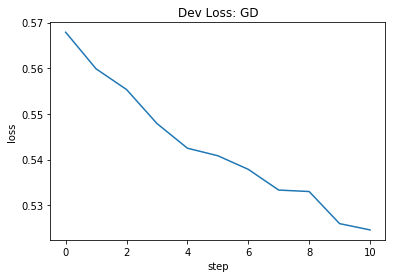

In [70]:
plt.plot(pd.Series(steps), pd.Series(loss))
plt.title('Dev Loss: GD')
plt.xlabel('step')
plt.ylabel('loss')
plt.show()

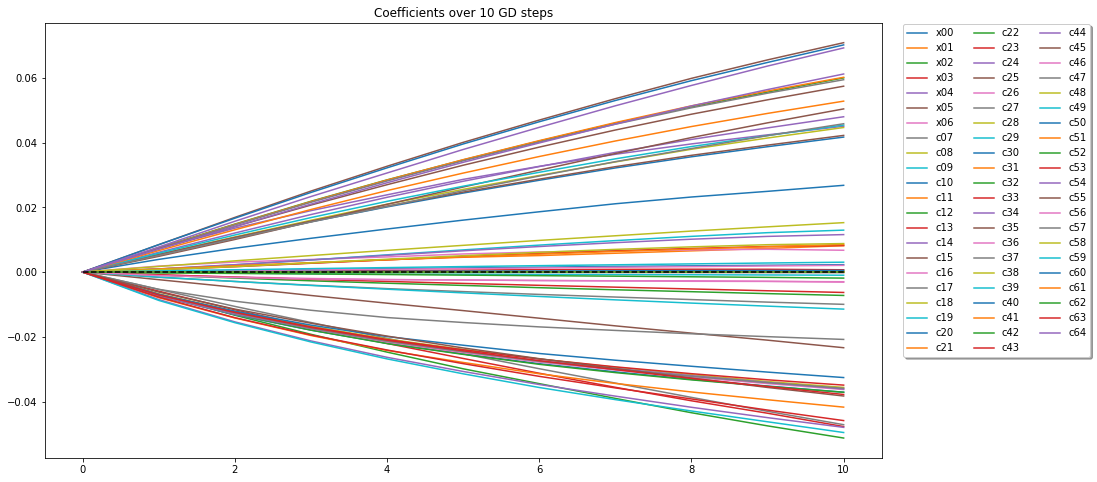

In [71]:
def plotCoeffs(models, steps, featureNames, title):
    """
    Helper Function to show how coefficients change as we train.
    """
    fig, ax = plt.subplots(figsize = (15,8))
    #X = list(range(len(models)))
    X = steps
    for data, name in zip(models.T, featureNames):
        if name == "Bias":
            continue
        ax.plot(X, data, label=name)
    ax.plot(X,[0]*len(X), 'k--')
    plt.title(title)
    plt.legend(loc='lower left', bbox_to_anchor=(1.02, 0.22), ncol=3, fancybox=True, shadow=True)
    plt.show
    
coeffs = [model[1:] for model in models]

plotCoeffs(np.array(coeffs), steps, FIELDS, "Coefficients over " + str(steps[-1]) + " GD steps")

### 7. Evaluation

We select the last trained model for evaluation.

We also compare it to the BASELINE model.

To save time, we evaluate the model performance using one of the test files, instead of the whole test set.

In [72]:
# use the last model for evaluation
model = models[-1]
outFile = './FinalModel.pkl'
with open(outFile, 'wb') as fp:
    pickle.dump(model, fp)
!gsutil cp ./FinalModel.pkl gs://final-project-w261-ads-data/notebooks/final-model/FinalModel.pkl

Copying file://./FinalModel.pkl [Content-Type=application/octet-stream]...
/ [1 files][  686.0 B/  686.0 B]                                                
Operation completed over 1 objects/686.0 B.                                      


Make predictions using both trained "model" and "BASELINE" model

In [75]:
# helper functions
sigmoid = lambda x: 1/(1+math.exp(-x)) 

def pred_label(prob):
    return 1 if prob >= .25 else 0

start = time.time()

# choosing dataset
eval_file_path = "gs://final-project-w261-ads-data/notebooks/output_files/transformed_parquet12122018/dev_full_batch/part-000*"

dataRDD = sqlContext.read.parquet(test_files[0]).rdd.map(lambda x: (x[0].toArray(), x[1]))

# prediction RDD (true_label, pred_label, flag, pred_prob) Trained Model
predRDD = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1]))\
                 .map(lambda x: (x[1], np.dot(x[0], model)))\
                 .map(lambda x: (x[0], x[1], sigmoid(x[1])))\
                 .map(lambda x: (x[0], x[1], x[2], pred_label(x[2])))\
                 .map(lambda x: (x[0], x[3], (x[0]==x[3])*1, x[2]))\
                 .cache()


# prediction RDD (true_label, pred_label, flag, pred_prob) BASELINE
baseline_predRDD = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1]))\
                      .map(lambda x: (x[1], np.dot(x[0], BASELINE)))\
                      .map(lambda x: (x[0], x[1], sigmoid(x[1])))\
                      .map(lambda x: (x[0], x[1], x[2], pred_label(x[2])))\
                      .map(lambda x: (x[0], x[3], (x[0]==x[3])*1, x[2]))\
                      .cache()

print(f"\n ... used {np.round(time.time() - start, 3)} seconds for this step")       


 ... used 155.014 seconds for this step


We collect predictions:

In [76]:
start = time.time()

y_true = predRDD.map(lambda x: x[0]).collect()    # true labels
y_pred = predRDD.map(lambda x: x[1]).collect()    # predicted labels 
y_prob = predRDD.map(lambda x: x[3]).collect()    # predicted probability of being "1"

y_true_baseline = baseline_predRDD.map(lambda x: x[0]).collect()    # true labels
y_pred_baseline = baseline_predRDD.map(lambda x: x[1]).collect()    # predicted labels 
y_prob_baseline = baseline_predRDD.map(lambda x: x[3]).collect()    # predicted probability of being "1"

print(f"\n ... used {np.round(time.time() - start, 3)} seconds for this step")       


 ... used 104.941 seconds for this step


#### (a) Accuracy

In [77]:
print(f"\n Trained model accuracy: {np.round(predRDD.map(lambda x: x[2]).mean(), 4)}") 
print(f"\n BASELINE model accuracy: {np.round(baseline_predRDD.map(lambda x: x[2]).mean(), 4)}")  


 Trained model accuracy: 0.6721

 BASELINE model accuracy: 0.2561


#### (b) F1 score, recall, precision

In [78]:
report = classification_report(y_true, y_pred)
report_baseline = classification_report(y_true_baseline, y_pred_baseline)

print("Trained Model:")
print(report)
print("BASELINE Model:")
print(report_baseline)

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Trained Model:
              precision    recall  f1-score   support

           0       0.84      0.69      0.76    340774
           1       0.41      0.63      0.49    117315

   micro avg       0.67      0.67      0.67    458089
   macro avg       0.63      0.66      0.63    458089
weighted avg       0.73      0.67      0.69    458089

BASELINE Model:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00    340774
           1       0.26      1.00      0.41    117315

   micro avg       0.26      0.26      0.26    458089
   macro avg       0.13      0.50      0.20    458089
weighted avg       0.07      0.26      0.10    458089



#### (c) ROC_AUC

Trained model AUC: 0.716
Baseline model AUC: 0.5


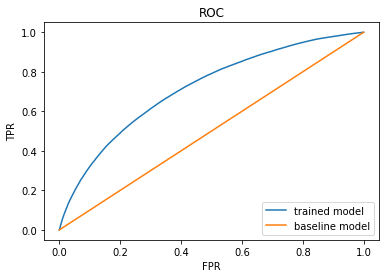

In [79]:
fpr, tpr, thresh = roc_curve(y_true, y_prob)  

fpr_baseline, tpr_baseline, thresh_baseline = roc_curve(y_true_baseline, y_prob_baseline)  

auc = roc_auc_score(y_true, y_prob)
print("Trained model AUC: {:.3}".format(auc))

auc_baseline = roc_auc_score(y_true_baseline, y_prob_baseline)
print("Baseline model AUC: {:.3}".format(auc_baseline))


plt.plot(fpr, tpr, label="trained model")
plt.plot(fpr_baseline, tpr_baseline, label="baseline model")
plt.legend(loc='lower right')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.show()

We chose AUC-ROC curve (Area Under the Curve of the Receiver Operating Characteristics) to evaluate our model. We chose this because AUC is not dependent on the decision boundary for the outcome variable, but instead only depends on predicted probabilities.  The outcome variable in this dataset is unbalanced (25% of 1 and 75% of 0, instead of 50-50), so we could potentially get different accuracy numbers in our baseline model by arbitrarily changing the threshold for prediction labels, thus making improvements to accuracy difficult to track. 

The baseline model in AUC assumes a label of 1 for every sample, so the baseline model accuracy will always be 25% for this dataset (because 25% of the dataset has an outcome variable of 1). Thus improvements to accuracy in logistic regression can be better evaluted when using AUC than with other accuracy measures.

We see an improvement in the AUC to 0.716 in our trained model from 0.5 in the baseline model, indicating that we are on the right track with our algorithm.  It's likely that further improvements could be made with improved, optimized feature engineering and more model training.

Reference: https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5

## Section 5: Application of Course Concepts

### Key Concepts:  
We illustrated in our code for this project several concepts that we discussed in class this semester:  

-  __Bias/Variance Trade-off:__  If we had left the categorical variables that had many unique levels in place then our model would have very high variance as a result of overfitting.  

-  __Parallel Programming:__  In order to efficently process 45 Million rows of records to compute basic statistics for exploring the data - we chose to use Spark's implementation of the Map/Reduce parallel programming framework.  This allowed us to quickly process all the data - which was required to get a sense for the number of unique values for each categorical feature, the count of records at each level for each categorical variable etc that could not have been accomplished with a sample of the data.  

-  __One-Hot Encoding:__ We had a number of categorical variables in our data set with hundreds of thousands of different values. These categorical variables needed to be represented numerically in order to feed into one of our algorithms, but we needed to do some dimensionality reduction before moving on so that we didn't end up with thousands of columns. Once we transformed our data, our one-hot encoding resulted in 65 columns and was very achievable on a standard cluster with modest amounts of CPUs and memory.  

- __Normalization:__ The continuous integer variables in this dataset spanned wide numeric ranges on different scales. Had we left them in that state, the varying scales of those variables would have caused the gradient descent to fail to converge.  To normalize the continuous variables, first we calculated the mean and standard deviation for each variable based on the training data, excluding missing values.  Then we transformed each value in the continuous variables in both the training and the test dataset into a Z-score, specifically, the current value minus the mean for that variable, divded by the standard deviation for that variable.  This results in continuous variables that are all scaled with a mean of zero and a standard deviation of one.  Subsequently we replaced missing values with the mean of the normalized variables, which is zero.  
Some variables had outliers up to almost 100 standard deviations away from the mean, which may be extreme enough to violate an assumption for logistic regression, that no influential values exist in the continuous predictors.  Were we to spend more time on feature engineering, we would examine those continuous variables in more detail and consider transforming or eliminating outliers beyond a certain threshold of standard deviation.  

- __Regularization:__ We implemented lasso regularization in a test notebook, though we did not end up running our implementation of regularization on the full dataset. The large number of variables make regularization a natural next step to explore for improving the model.  Even after work we did in Sections 3 and 4 to reduce dimensionality, we still ended up with about 60 features, which could result in overfitting. Lasso regularization in particular could eliminate some of those extra variables and narrow down the model to a smaller number of coefficients that are more interpretable and also less likely to result in overfitting. 